In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


In [0]:
pip install pycountry

Python interpreter will be restarted.
Python interpreter will be restarted.


DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20240329092717/", (29 March 2024)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/', 'v008.20230821105000/', 'v008.20231003094404/', 'v008.20240329092717/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-4c8f7abf-824f-482b-97cb-0ac977181fb6/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-4c8f7abf-824f-482b-97cb-0ac977181fb6/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmphau4x05p
       cwd: /tmp/pip-install-lcw6owcz/rpy2_e8f17abec1a742cdbddd35435148eb69
  Complete output (16 lines):
  Traceback (most recent call last):
    File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-4c8f7abf-824f-482b-97cb-0ac977181fb6/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 349, 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','news_cnt','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  #newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  #newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))

  newdf = newdf.withColumn('auth_seq', F.col('Au_Af').getItem('Authorseq'))
  newdf = newdf.withColumn('aff_seq', F.col('Au_Af').getItem('affiliation_seq'))
  newdf = newdf.withColumn("auth_pos", F.expr("array_position(auth_seq, cor_seq_first)"))

  newdf = newdf.withColumn("auth_pos", newdf["auth_pos"].cast(IntegerType()))  
  #newdf = newdf.filter(F.col('aff_seq').isNotNull())
  newdf = newdf.filter(F.col('auth_pos') != 0)
  newdf = newdf.withColumn("aff", F.element_at(newdf['aff_seq'], newdf['auth_pos']))
  newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  newdf = newdf.withColumn("cor_afid", F.col('aff_val').getItem('afid'))

  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("cor1_given_name", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  display(newdf.limit(10))

  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2

def get_gender(newdf):
  df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference)
  #non_null_count = newdf.where(F.col('Au1_id').isNotNull()).count()
  mergedf = df_gender.join(newdf, newdf.Au1_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender,newdf.doi,newdf.news_cnt,newdf.Au,newdf.Eid, newdf.year, newdf.publication_type,newdf.openaccess, newdf.issn, 
      newdf.num_au, newdf.Au1_id,newdf.Au2_id,newdf.Au_cor_id, newdf.srcid, newdf.subfield_article, newdf.subfield_journal, newdf.subfield_hybrid,newdf.correspondence,
      newdf.cor1_given_name, newdf.cor_afid)
  mergedf = mergedf.withColumnRenamed('Inferred_Probable_Gender', 'Au1_gender')

  mergedf2 = df_gender.join(mergedf, mergedf.Au2_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf.doi,mergedf.news_cnt,mergedf.Au,mergedf.Eid, mergedf.year, mergedf.publication_type,mergedf.openaccess, mergedf.issn, 
      mergedf.num_au, mergedf.Au1_id,mergedf.Au2_id,mergedf.Au_cor_id, mergedf.srcid, mergedf.subfield_article, mergedf.subfield_journal, mergedf.subfield_hybrid, mergedf.Au1_gender,mergedf.correspondence,mergedf.cor1_given_name,mergedf.cor_afid)
  mergedf2 = mergedf2.withColumnRenamed('Inferred_Probable_Gender', 'Au2_gender')

  #mergedf2 = mergedf2.withColumn('no_cor', F.size(mergedf2['Au_cor_id']))
  #display("len os final4 ", mergedf2.count(),"\n")

  mergedf2 = mergedf2.withColumn('cor_au1', first(mergedf2['Au_cor_id']))

  #display(final_data4.limit(20))

  mergedf3 = mergedf2.filter(F.col('cor_au1').isNotNull())
  display("no of not null cor au",mergedf3.count(),"\n")

  mergedf4 = df_gender.join(mergedf3, mergedf3.cor_au1 == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf3.doi,mergedf3.news_cnt,mergedf3.Au,mergedf3.Eid, mergedf3.year, mergedf3.publication_type,mergedf3.openaccess, mergedf3.issn, 
      mergedf3.num_au, mergedf3.Au1_id,mergedf3.Au2_id,mergedf3.Au_cor_id, mergedf3.srcid, mergedf3.subfield_article, mergedf3.subfield_journal, mergedf3.subfield_hybrid, mergedf3.Au1_gender,mergedf3.Au2_gender,mergedf3.cor_au1,mergedf3.correspondence,mergedf3.cor1_given_name, mergedf3.cor_afid)
  mergedf4 = mergedf4.withColumnRenamed('Inferred_Probable_Gender', 'cor_gender')

  return mergedf4

def merge_news_cnt(scop):
  scop = scop.filter(func.col('year') >= 2018)
  scop = scop.filter(func.col('year') <= 2022)
  df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_news_final.csv")
  display("# doi data from crossref and altmetric ",df1.count(),"\n")
  df = scop.join(df1, 'doi','inner')
  df = df.withColumn("news_cnt", df["news_cnt"].cast(IntegerType()))
  return df

from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
display("len of df_ani in english ",d2.count(),"\n")

with_news = merge_news_cnt(d2)
display("merged data len between crossref and scopus ",with_news.count(),"\n")

newdf = extract_publication_info(with_news)

df_class = get_smc_classification(newdf)
final_data = get_gender(df_class)
display(final_data.count(),"\n")
final_data2 = final_data.dropna(subset=["doi"])
display(final_data2.count(),"\n")

##extracting sci_val topic for each publication
df_top_eids = spark.read.format("parquet").load(basePath+tablename_top_topic_eid)

final_data3 = final_data2.join(df_top_eids,'Eid','inner')
#display(final_data3.count())
display(final_data3.limit(10))


import pyspark.sql.functions as F
import pyspark.sql.column as C

def find_sjr(met,yy,yr):

  ylst = F.tolist(yy)

  #index = ylst.index(yr)
  #sjr = m[index]
  return m


df_sources = spark.read.format("parquet").load(basePath+tablename_sources)

data = final_data3.join(df_sources,'srcid','inner').select(df_sources.metrics_calculations,df_sources.sourcetitle,df_sources.openaccess_status,final_data3.srcid,final_data3.doi,final_data3.news_cnt,final_data3.year,
final_data3.publication_type, final_data3.issn, final_data3.num_au,final_data3.Au1_id, final_data3.subfield_article,final_data3.subfield_journal, final_data3.Au1_gender,final_data3.TopicId, 
final_data3.cor_gender,final_data3.cor_au1,final_data3.correspondence, final_data3.cor1_given_name, final_data3.cor_afid)

display("len of merged data between src ", data.count(),"\n")

data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))

#data = data.withColumn('SJR', find_sjr(data['SJR_lst'],data['year_SJR'], data['year']))
data = data.withColumn("pos", F.expr("array_position(year_SJR, year)"))


data = data.withColumn("pos", data["pos"].cast(IntegerType()))  
data = data.withColumn("SJR", F.element_at(data['SJR_lst'], data['pos']))

data = data.withColumn('cor_af', first(data['correspondence']))
data = data.withColumn('cor_coun', F.col('cor_af').getItem('country'))



import pycountry
import pyspark.sql.functions as F

def convert_country_short_name(country_short_name):
  #country = pycountry.countries.get(alpha_2=country_short_name)
  if len(country_short_name) == 3:
    country = pycountry.countries.get(alpha_3=country_short_name)
  else:
    country = pycountry.countries.get(alpha_2=country_short_name)

  return country.name if country else None

@F.udf(returnType=F.StringType())
def my_udf(country_short_name):
  return convert_country_short_name(country_short_name)

data = data.filter(F.col('cor_coun').isNotNull())
data = data.withColumn("country_name", my_udf(data["cor_coun"]))
#un_full_coun = un_name.withColumn("country_name", my_udf(un_name["cor_coun"]))

df_ipr = spark.read.format("parquet").load(basePath+tablename_ipr)
data = data.join(df_ipr,[data.cor_afid == df_ipr.afid],'inner')
display(data.limit(10))

val_data = data.filter(func.col('cor_gender') != 'unknown')

#val_un = data.filter(func.col('cor_gender') == 'unknown')



display("len of data whose cor_gender is not unknown ",val_data.count(),"\n")

display(val_data.limit(5),"\n")


#val_un = data.filter(func.col('cor_gender') == 'unknown')
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
#un_full_coun = val_un.join(df_apr,val_un.cor_au1 == df_apr.auid,'inner')
un_full_coun = data.filter(func.col('cor_gender') == 'unknown')

display("len of unknown name ", un_full_coun.count(),"\n")
un_full_coun = un_full_coun.filter(F.col('cor1_given_name').isNotNull())
un_full_coun = un_full_coun.filter(F.col('country_name').isNotNull())
display("len of unknown name after dropping null country and given name ", un_full_coun.count(),"\n")
df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
#df_wos.printSchema()
#df_wos = df_wos.filter(func.col('country') == 'China')
newfile = un_full_coun.join(df_wos,[un_full_coun.cor1_given_name == df_wos.givenname,un_full_coun.country_name == df_wos.country],'inner')
display("len or merged gender with wos ", newfile.count(),"\n")

In [0]:
ddf2 = newfile.drop("cor_gender")
ddf3 = ddf2.withColumnRenamed("gender", "cor_gender")
#ddf3.printSchema()
#display(ddf3.select('cor_gender').distinct())
ddf4 = ddf3.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type','cor_au1').toPandas()
print(ddf4.head(5)) 

ddfx = val_data.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type','cor_au1').toPandas()
display(len(ddfx),"\n")
display(len(ddf4),"\n")
ddf = ddfx.append(ddf4, ignore_index = True)
display(len(ddf),"\n")

In [0]:
###new version
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc = smc.drop_duplicates()
print(len(smc))
smc['SubField_English'] = smc['SubField_English'].str.lower()
ddf['subfield_article'] = ddf['subfield_article'].str.lower()

#print(smc.dtypes)
total = smc.merge(ddf,left_on='SubField_English',right_on = 'subfield_article',how = 'inner')
print(len(total))

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))
#us.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us.csv", index = False)

##Read saved file and extract the US authors and Descriptive analysis of the dataset

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
print(total.dtypes)

print("len of total ", len(total))
print(total['doi'].nunique())
total = total.drop_duplicates(subset = ['doi'])

print("len of total after dropping duplicate dois ", len(total))

Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
dtype: object
len of total  1014175
1014077
len of total after dropping duplicate dois  1014077


In [0]:
#total[total['issn'] == "00280836"]
#total['subfield_article'].nunique()

In [0]:
#total['cor_gender'].unique() //array(['female', 'male', 'M', 'F', 'f', 'm'], dtype=object)
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
print(len(total))
total2 = total[~total['doi'].isin(ids_to_remove)]
print(len(total2))
us = total2[total2['country_name'] == 'United States']
print(len(us))
print(len(us[us['news_cnt'] > 0]))
print(len(us[us['news_cnt'] <= 0]))

1014077
1014035
1014035
129428
884607


In [0]:
dummy = us.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    elif dummy['cor_gender'][ind] == "male" or dummy['cor_gender'][ind] == "m" or dummy['cor_gender'][ind] == "M": ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

1014035


#### total distribution of gender in US

In [0]:
male = dummy[dummy['gender'] == "male"]
female = dummy[dummy['gender'] == "female"]
print("percent of male in US corresponding author ",(len(male)/len(dummy))*100)
print("percent of female in US corresponding author ",(len(female)/len(dummy))*100)

percent of male in US corresponding author  62.9459535420375
percent of female in US corresponding author  37.0540464579625


#### proportion of female corresponding author in the entire dataset

In [0]:
for i in dummy['Domain_English'].unique():
    x = dummy[dummy['Domain_English'] == i]
    f = x[x['gender'] == "female"]
    print(i," ",len(f)/len(x), " ",len(x))

Applied Sciences   0.2756088571347566   141084
Arts & Humanities   0.45486941224232036   22169
Economic & Social Sciences   0.45574042200548226   78435
Health Sciences   0.40573102682282836   601428
Natural Sciences   0.27503671329694185   170919


### proportion of female corresponding author in the entire dataset for fig 5

In [0]:
val = []
fld = []
for i in dummy['Field_English'].unique():
    x = dummy[dummy['Field_English'] == i]
    f = x[x['gender'] == "female"]
    #print(i," ",len(f)/len(x), " ",len(x))
    val.append(len(f)/len(x))
    fld.append(i)
print(fld)
print(val)

['Agriculture, Fisheries & Forestry', 'Built Environment & Design', 'Enabling & Strategic Technologies', 'Engineering', 'Information & Communication Technologies', 'Communication & Textual Studies', 'Historical Studies', 'Philosophy & Theology', 'Visual & Performing Arts', 'Economics & Business ', 'Social Sciences', 'Biomedical Research', 'Clinical Medicine', 'Psychology & Cognitive Sciences', 'Public Health & Health Services', 'Biology', 'Chemistry', 'Earth & Environmental Sciences', 'Mathematics & Statistics', 'Physics & Astronomy']
[0.3803458955353725, 0.3469635627530364, 0.23360429617096407, 0.23784612609362316, 0.28459437588509, 0.5281219272369715, 0.470699731480019, 0.2988847583643123, 0.4340277777777778, 0.3145703353900245, 0.5386047264486888, 0.35934419633876485, 0.3661885019069566, 0.5636568612028735, 0.6212673637267605, 0.3822159028765176, 0.21158025837016778, 0.33693880574899987, 0.22333912780591036, 0.20034977741437268]


#### proportion of female corresponding author in the cited dois

In [0]:
for i in dummy['Domain_English'].unique():
    x = dummy[dummy['Domain_English'] == i]
    x = x[x['news_cnt'] > 0]
    f = x[x['gender'] == "female"]
    print(i," ",len(f)/len(x)," ",len(x))

Applied Sciences   0.28761604484147835   11418
Arts & Humanities   0.44611528822055135   1596
Economic & Social Sciences   0.43682030036250646   7724
Health Sciences   0.4031598839764437   91016
Natural Sciences   0.2980083738825393   17674


In [0]:
for i in dummy['Field_English'].unique():
    x = dummy[dummy['Field_English'] == i]
    x = x[x['news_cnt'] > 0]
    f = x[x['gender'] == "female"]
    print(i," ",len(f)/len(x)," ",len(x))

Agriculture, Fisheries & Forestry   0.4230769230769231   2210
Built Environment & Design   0.3716577540106952   374
Enabling & Strategic Technologies   0.23098278734036645   5403
Engineering   0.25940054495912807   1835
Information & Communication Technologies   0.30451127819548873   1596
Communication & Textual Studies   0.5101265822784811   790
Historical Studies   0.3911504424778761   565
Philosophy & Theology   0.3640552995391705   217
Visual & Performing Arts   0.375   24
Economics & Business    0.350952894642215   2781
Social Sciences   0.48513048755816307   4943
Biomedical Research   0.335930514752842   15658
Clinical Medicine   0.3719642980696049   57812
Psychology & Cognitive Sciences   0.5475105485232068   5925
Public Health & Health Services   0.5753377506238706   11621
Biology   0.3758763543658381   6276
Chemistry   0.19522935779816514   2725
Earth & Environmental Sciences   0.3411949685534591   4452
Mathematics & Statistics   0.2986111111111111   144
Physics & Astronomy   

In [0]:
yr = 2018
while yr <= 2022:
    a = dummy[dummy['year'] == yr]
    a = a[a['news_cnt'] > 0]
    fm = a[a['gender'] == "female"]
    print(yr," ",len(fm)/len(a))
    yr += 1

2018   0.3584159258156451
2019   0.37256677229515617
2020   0.37163594552836765
2021   0.3964046796233474
2022   0.4083537102649833


#### Distribution of gender in cited group

In [0]:
cited = dummy[dummy['news_cnt'] > 0]
print(len(cited))

male = cited[cited['gender'] == "male"]
female = cited[cited['gender'] == "female"]
print("percent of male in cited US author ",(len(male)/len(cited))*100)
print("percent of female in cited US author ",(len(female)/len(cited))*100)

129428
percent of male in cited US author  61.88537256235127
percent of female in cited US author  38.11462743764873


#### percent of cited female stratified by year

In [0]:
y18 = dummy[dummy['year'] <= 2019]

y20 = dummy[dummy['year'] >= 2020]

cited_18 = y18[y18['news_cnt'] > 0]
cited_20 = y20[y20['news_cnt'] > 0]

male = cited_18[cited_18['gender'] == "male"]
female = cited_18[cited_18['gender'] == "female"]
print("percent of male in cited US author ",(len(male)/len(cited_18))*100)
print("percent of female in cited US author ",(len(female)/len(cited_18))*100)


male = cited_20[cited_20['gender'] == "male"]
female = cited_20[cited_20['gender'] == "female"]
print("percent of male in cited US author ",(len(male)/len(cited_20))*100)
print("percent of female in cited US author ",(len(female)/len(cited_20))*100)

percent of male in cited US author  63.40844113001579
percent of female in cited US author  36.591558869984205
percent of male in cited US author  60.92606817695282
percent of female in cited US author  39.07393182304719


#### us only, percent of female correnponding author based on field classification

['Public Health & Health Services', 'Psychology & Cognitive Sciences', 'Social Sciences', 'Communication & Textual Studies', 'Historical Studies', 'Visual & Performing Arts', 'Biology', 'Agriculture, Fisheries & Forestry', 'Clinical Medicine', 'Biomedical Research', 'Built Environment & Design', 'Earth & Environmental Sciences', 'Economics & Business ', 'Philosophy & Theology', 'Information & Communication Technologies', 'Engineering', 'Enabling & Strategic Technologies', 'Mathematics & Statistics', 'Chemistry', 'Physics & Astronomy']


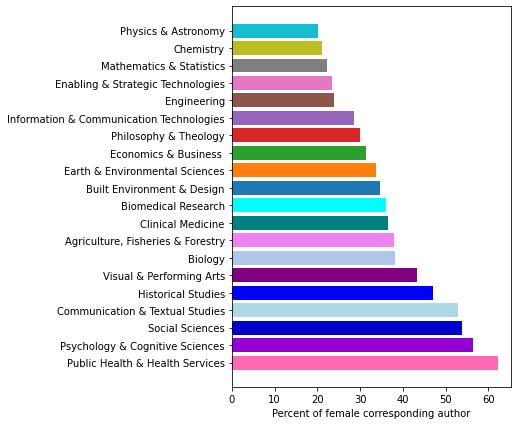

In [0]:
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
import seaborn as sns
domain = dummy['Field_English'].unique()
female = []
#print(len(mcolors.TABLEAU_COLORS))
#print(len(mcolors.CSS4_COLORS))
color = ['hotpink','darkviolet','mediumblue','lightblue', 'blue', 'purple', '#aec7e8', 'violet','teal','aqua']
#color = []

for c in mcolors.TABLEAU_COLORS:
  color.append(c)
  if len(color) == 20:
    break


for i in domain:
  tc = dummy[dummy['Field_English'] == i]

  tc_female = len(tc[tc['gender'] == 'female']) 
  female.append((tc_female/len(tc))*100)

#print("domain ",domain)
#print("female percent ", female)
fig = plt.figure(figsize =(5, 7))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female_total'] = female

samp = samp.sort_values(by = ['female_total'], ascending=False)

aax = samp['domain']
print(list(aax))
plt.barh(samp['domain'], samp['female_total'], color = color)
#ax = sns.barplot(samp, x = "female_total", y = "domain",hue = "domain")
#ax.legend_.remove()
plt.xlabel("Percent of female corresponding author")

plt.show()

In [0]:
#print(samp)
a = ['Agriculture, Fisheries & Forestry','Built Environment & Design','Enabling & Strategic Technologies', 'Engineering','Information & Communication Technologies',
    'Communication & Textual Studies','Historical Studies','Philosophy & Theology','Visual & Performing Arts',
'Economics & Business ','Social Sciences',
                   'Biomedical Research','Clinical Medicine','Psychology & Cognitive Sciences','Public Health & Health Services',
                   'Biology','Chemistry','Earth & Environmental Sciences','Mathematics & Statistics','Physics & Astronomy']

fem = []
for i in a:
    x = samp[samp['domain'] == i]
    #print(x)
    fem.append(x.iloc[0]['female_total'])
print(fem)
print(len(fem))

[38.03458955353725, 34.69635627530364, 23.360429617096408, 23.784612609362316, 28.459437588509, 52.81219272369715, 47.0699731480019, 29.888475836431226, 43.40277777777778, 31.45703353900245, 53.860472644868885, 35.93441963387649, 36.61885019069566, 56.36568612028735, 62.12673637267605, 38.22159028765176, 21.158025837016776, 33.693880574899985, 22.333912780591035, 20.034977741437267]
20


#### us only, percent of female correnponding author in the cited group based on field classification

domain  ['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies'
 'Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts'
 'Economics & Business ' 'Social Sciences' 'Biomedical Research'
 'Clinical Medicine' 'Psychology & Cognitive Sciences'
 'Public Health & Health Services' 'Biology' 'Chemistry'
 'Earth & Environmental Sciences' 'Mathematics & Statistics'
 'Physics & Astronomy']
female percent  [42.30769230769231, 37.16577540106952, 23.098278734036644, 25.940054495912808, 30.451127819548873, 51.01265822784811, 39.11504424778761, 36.405529953917046, 37.5, 35.0952894642215, 48.51304875581631, 33.593051475284206, 37.19642980696049, 54.75105485232068, 57.53377506238706, 37.58763543658381, 19.522935779816514, 34.11949685534591, 29.86111111111111, 19.965661025263675]


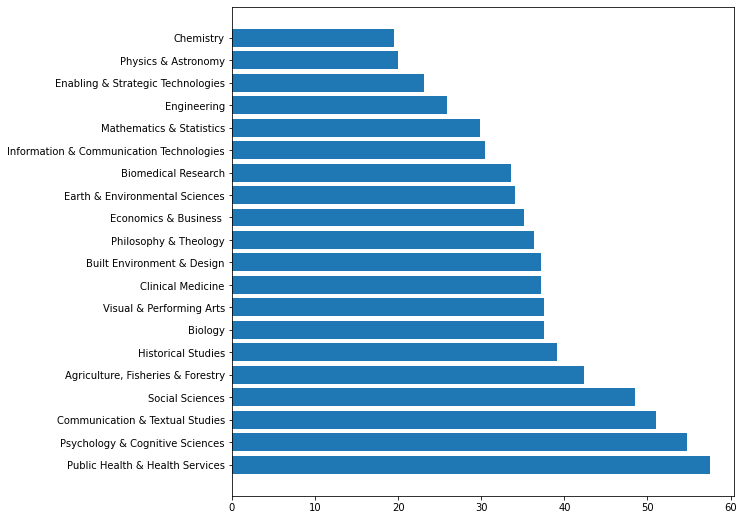

In [0]:

domain = dummy['Field_English'].unique()
female = []

for i in domain:
  tc = dummy[dummy['Field_English'] == i]
  tc = tc[tc['news_cnt'] > 0]
  tc_female = len(tc[tc['gender'] == 'female'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(9, 9))
 
samp2 = pd.DataFrame()
samp2['domain'] = domain
samp2['female_cit'] = female

samp2 = samp2.sort_values(by = ['female_cit'], ascending=False)

plt.barh(samp2['domain'], samp2['female_cit'])

plt.show()

In [0]:
merge = samp.merge(samp2, on = ['domain'], how = "inner")
print(merge)

                                      domain  female_total  female_cit
0            Public Health & Health Services     62.126736   57.533775
1            Psychology & Cognitive Sciences     56.365686   54.751055
2                            Social Sciences     53.860473   48.513049
3            Communication & Textual Studies     52.812193   51.012658
4                         Historical Studies     47.069973   39.115044
5                   Visual & Performing Arts     43.402778   37.500000
6                                    Biology     38.221590   37.587635
7          Agriculture, Fisheries & Forestry     38.034590   42.307692
8                          Clinical Medicine     36.618850   37.196430
9                        Biomedical Research     35.934420   33.593051
10                Built Environment & Design     34.696356   37.165775
11            Earth & Environmental Sciences     33.693881   34.119497
12                     Economics & Business      31.457034   35.095289
13    

## read saved file and conduct CEM matching

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
print(total.dtypes)


ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total2 = total[~total['doi'].isin(ids_to_remove)]

print("len of total ", len(total))
total2 = total2.dropna(subset=['srcid','year','num_au','subfield_article','cor_gender']) #replace TopicId with subfield_article
total2 = total2.drop_duplicates()
total2 = total2.drop_duplicates(subset = ['doi'])


print("after dropping null and duplicates ",len(total2))

total2 = total2[total2['country_name'] == 'United States']
print("len of united states after dropping null and duplicates", len(total2))



total2['TopicId'] = total2['TopicId'].astype(str)
total2['srcid'] = total2['srcid'].astype(str)
total2['cor_au1'] = total2['cor_au1'].astype(str)

new_yr = []
coarse_team = []
treatment = []


for ind in total2.index:
  '''if total2['year'][ind] == 2018 or total2['year'][ind] == 2019:
    new_yr.append('1')
  elif total2['year'][ind] == 2020 or total2['year'][ind] == 2021 or total2['year'][ind] == 2022:
    new_yr.append('2')'''    
  if total2['year'][ind] == 2018:
    new_yr.append('1')
  elif total2['year'][ind] == 2019:
    new_yr.append('2')
  elif total2['year'][ind] == 2020:
    new_yr.append('3')
  elif total2['year'][ind] == 2021:
    new_yr.append('4')
  elif total2['year'][ind] == 2022:
    new_yr.append('5')
  

for ind in total2.index:  
  if total2['num_au'][ind] == 1:
    coarse_team.append('1')
  elif total2['num_au'][ind] == 2:
    coarse_team.append('2')
  elif total2['num_au'][ind] == 3:
    coarse_team.append('3')
  elif total2['num_au'][ind] >= 4 and total2['num_au'][ind] <= 5:
    coarse_team.append('4')
  elif total2['num_au'][ind] >= 6 and total2['num_au'][ind] <= 9:
    coarse_team.append('5')
  elif total2['num_au'][ind] > 9:
    coarse_team.append('6')


for ind in total2.index:
  if total2['news_cnt'][ind] > 0:
    treatment.append('1')
  elif total2['news_cnt'][ind] == 0:
    treatment.append('0')

  


total2['year_cat'] = new_yr
total2['team_size'] = coarse_team
total2['treatment'] = treatment

print(total2.dtypes)

print(len(total2))




from collections import defaultdict


def match_data(data,treatment,control_var):

    
    ##get unique control tuples
    con_data = data[control_var] #control_var is a list of control variables, other than treatment,doi and gender
    un_con = con_data.drop_duplicates()
    
    ##create map of strata for unique control tuples
    mydict = defaultdict(list)
    cnt = 1
    '''for i, tup in enumerate(un_con.iterrows()):
        _, x_row = tup
        #print(x_row)
        mydict[tuple(x_row)] = cnt
        cnt += 1'''
    
    #print(mydict)
    new_data = data[control_var]
    strata = []
    
    for i, tup in enumerate(new_data.iterrows()):
        _, x_row = tup
        if tuple(x_row) in mydict:
            strata.append(mydict[tuple(x_row)])
        else:
            mydict[tuple(x_row)] = cnt
            cnt += 1
            strata.append(mydict[tuple(x_row)])
    data['strata'] = strata
    display("done with step 1","\n")
    
    
    
    value_counts = data["strata"].value_counts()

# Create a list of the values that have only one instance
    single_instances = value_counts[value_counts == 1].index

# Filter the DataFrame to only include rows where the "dog" value is not in the list of single_instances
    data = data[~data["strata"].isin(single_instances)]
    
    
    data["st_tr"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '1']))

    data["st_con"] = data.groupby("strata")[treatment].transform(lambda x: len(x[x == '0']))
    
    data = data.loc[(data["st_tr"] != 0) & (data["st_con"] != 0)]
    
    st_tr = dict(zip(data['strata'], data['st_tr']))
    st_con = dict(zip(data['strata'], data['st_con']))

    display("done with step 2","\n")
    
    new = data.copy()
    
    mt = new[new[treatment] == '1']
    mc = new[new[treatment] == '0']

    new['weight'] = new['strata'].apply(lambda x: (len(mc)*st_tr[x]) / (len(mt)*st_con[x]))
    #new['weight'] = new[treatment].apply(lambda x: 1.00 if x == '1')
    row_index = new[new[treatment] == '1'].index

    # Replace all the values in the age column where the row index is in row_index with 1
    new.loc[row_index, "weight"] = 1.00
    
    
    
    
    '''weight = []
    for ind in new.index:
        s = new['strata'][ind]
        
        if new[treatment][ind] == '1':
            weight.append(1)
        else:
            ns = new[new['strata'] == s]
            mts = ns[ns[treatment] == '1']
            mcs = ns[ns[treatment] == '0']
                
            #t = new[new['strata'] != -1]
                
            
                
            weight.append((len(mc)*len(mts))/(len(mt)*len(mcs)))
    new['weight'] = weight'''
    return new
new = match_data(data = total2.copy(deep = True),treatment="treatment",control_var=['srcid','openaccess_status','year_cat','team_size','subfield_article']) #'TopicId'
#new = match_data(data = total2,treatment="treatment",control_var=['srcid','year_cat','team_size','TopicId'])


t = new[new['treatment'] == '1']
print(len(t))
c = new[new['treatment'] == '0']
print(len(c))

ft = t[t['cor_gender'] == 'female']
ft1 = t[t['cor_gender'] == 'f']
ft2 = t[t['cor_gender'] == 'F']


fc = c[c['cor_gender'] == 'female']
fc1 = c[c['cor_gender'] == 'f']
fc2 = c[c['cor_gender'] == 'F']



print((len(ft)+len(ft1)+len(ft2))/len(t)," ", (len(fc)+len(fc1)+len(fc2))/len(c)) ##0.02 more in treatment group


Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
dtype: object
len of total  1014175
after dropping null and duplicates  1014035
len of united states after dropping null and duplicates 1014035
Domain_English        object
Field_English         object
SubField_English      object
srcid                 object
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender     

In [0]:
print(len(new))
print(new['doi'].nunique())

In [0]:
dummy = new.copy(deep = True)
print(len(dummy))
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
        #gender.append(0)
    elif dummy['cor_gender'][ind] == "male" or dummy['cor_gender'][ind] == "m" or dummy['cor_gender'][ind] == "M": ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
        #gender.append(1)
dummy['gender'] = gender

421038
421038


In [0]:
new[new['strata'] == 7]

#### assign quantile

In [0]:
'''q1 = total['SJR'].quantile(0.25)
q2 = total['SJR'].quantile(0.50)
q3 = total['SJR'].quantile(0.75)
print("q1 ",q1," q2 ",q2," q3 ",q3)
q = []
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q
'''

'''a = pd.DataFrame()
a['srcid'] = total['srcid']
a['SJR'] = total['SJR']
print(len(a))
a = a.drop_duplicates()
print(len(a))
q1 = a['SJR'].quantile(0.25)
q2 = a['SJR'].quantile(0.50)
q3 = a['SJR'].quantile(0.75)'''

q1, q2, q3 = 0.124, 0.25, 0.597

print("q1 ",q1," q2 ",q2," q3 ",q3)
q = []
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

q1  0.124  q2  0.25  q3  0.597


#### quantile based regression analysis

In [0]:
def domain(a):
  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t[t['gender'] == "female"])/len(t))
  print("length of control ",len(c[c['gender'] == "female"])/len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]

  out = []

  cov = []
  c1 = []
  c0 = []

  
  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
      
    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)
  a['outcome'] = out

  a['covid'] = cov

  for ind in a.index:
    if a['covid'][ind] == 1:
      c1.append(1)
      c0.append(0)
    else:
      c1.append(0)
      c0.append(1)
  #a['c1'] = c1
  #a['c0'] = c0
  return a
  

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
MASS = importr('MASS')

#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages('questionr')
questionr = importr('questionr')

---------------------------------------------------------------------------
PackageNotInstalledError                  Traceback (most recent call last)
<command-3196390998680751> in <cell line: 21>()
     19 #utils.chooseCRANmirror(ind=1)
     20 #utils.install_packages('questionr')
---> 21 questionr = importr('questionr')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-70fc8092-d126-440c-90ea-b064f0d42af4/lib/python3.9/site-packages/rpy2/robjects/packages.py in importr(name, lib_loc, robject_translations, signature_translation, suppress_messages, on_conflict, symbol_r2python, symbol_resolve, data)
    470 
    471     if not isinstalled(name, lib_loc=lib_loc):
--> 472         raise PackageNotInstalledError(
    473             'The R package "%s" is not installed.' % name
    474         )

PackageNotInstalledError: The R package "questionr" is not installed.

In [0]:


#controlling for SubField_English
#a = domain(dummy[dummy['q'] == 0]) #insig
#a = domain(dummy[dummy['q'] == 1])  #insig
a = domain(dummy[dummy['q'] == 2]) # sig est = -9.61737102e-02, p val =   0.0337 *
#a = domain(dummy[dummy['q'] == 3]) #insig

#controlling for Field_English, basically results are same as controlling for Subfield
#a = domain(dummy[dummy['q'] == 0]) #insig
#a = domain(dummy[dummy['q'] == 1])  #insig
#a = domain(dummy[dummy['q'] == 2]) # sig est = -0.0896210, p val =   0.0404 * 
#a = domain(dummy[dummy['q'] == 3]) #insig


with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('outcome')
col_2 = ro.vectors.FactorVector(tst_df.rx2('outcome'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+SubField_English+team_size+openaccess_status+covid",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

In [0]:
questionr.odds.ratio(base.summary(model), level=0.95)

In [0]:
stats.confint(model)

In [0]:
import numpy as np
coeffs = base.summary(model).rx2('coefficients')
print(np.array(coeffs))

#### percent difference of male and female in Treatment and control group after CEM

Public Health & Health Services   -0.08142623870757437  treatment length  8593  control length  23666
Public Health & Health Services    prop of fem in treatment  59.42045851274293  and control  64.68773768275162
Psychology & Cognitive Sciences   -0.015235781546837709  treatment length  4058  control length  11096
Psychology & Cognitive Sciences    prop of fem in treatment  56.16067028092656  and control  57.02956020187455
Social Sciences   -0.08250415831673862  treatment length  3140  control length  11202
Social Sciences    prop of fem in treatment  49.617834394904456  and control  54.07962863774326
Communication & Textual Studies   0.027130240241411967  treatment length  523  control length  1441
Communication & Textual Studies    prop of fem in treatment  52.39005736137668  and control  51.006245662734216
Historical Studies   -0.15044988491316177  treatment length  342  control length  1064
Historical Studies    prop of fem in treatment  42.39766081871345  and control  49.906015037

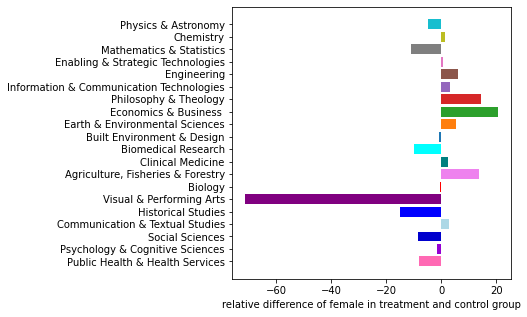

In [0]:
import matplotlib.pyplot as plt 

import matplotlib.colors as mcolors
import seaborn as sns
domain = dummy['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(5, 5))

color = ['hotpink','darkviolet','mediumblue','lightblue', 'blue', 'purple', 'red', 'violet','teal','aqua']
#color = []

for c in mcolors.TABLEAU_COLORS:
  color.append(c)
  if len(color) == 20:
    break

aax = ['Public Health & Health Services', 'Psychology & Cognitive Sciences', 'Social Sciences', 'Communication & Textual Studies', 'Historical Studies', 'Visual & Performing Arts', 'Biology', 'Agriculture, Fisheries & Forestry', 'Clinical Medicine', 'Biomedical Research', 'Built Environment & Design', 'Earth & Environmental Sciences', 'Economics & Business ', 'Philosophy & Theology', 'Information & Communication Technologies', 'Engineering', 'Enabling & Strategic Technologies', 'Mathematics & Statistics', 'Chemistry', 'Physics & Astronomy']
for i in aax:
  tc = dummy[dummy['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['gender'] == 'female']) 
  c_female = len(c[c['gender'] == 'female'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append((((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))*100)
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
  print(i," "," prop of fem in treatment ",(t_female/len(t))*100, " and control ",(c_female/len(c))*100)
plt.barh(aax, diff, color = color)
plt.xlabel("relative difference of female in treatment and control group")

In [0]:
#print(samp)
a = ['Agriculture, Fisheries & Forestry','Built Environment & Design','Enabling & Strategic Technologies', 'Engineering','Information & Communication Technologies',
    'Communication & Textual Studies','Historical Studies','Philosophy & Theology','Visual & Performing Arts',
'Economics & Business ','Social Sciences',
                   'Biomedical Research','Clinical Medicine','Psychology & Cognitive Sciences','Public Health & Health Services',
                   'Biology','Chemistry','Earth & Environmental Sciences','Mathematics & Statistics','Physics & Astronomy']
diff =[]
for i in a:
  tc = dummy[dummy['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['gender'] == 'female']) 
  c_female = len(c[c['gender'] == 'female'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append((((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))*100)
print(diff)

[13.616095282877735, -0.954131652661057, 0.635841352241079, 5.916809037341788, 3.0697154045171517, 2.7130240241411965, -15.044988491316177, 14.56753809873976, -71.42857142857143, 20.670381361579267, -8.25041583167386, -9.773949005571039, 2.4357206312478152, -1.523578154683771, -8.142623870757436, -0.4839214657396361, 1.2785555440780114, 5.219749165308836, -10.852713178294572, -4.74047060548306]


treatment  96350  female  0.3805604566683965  control  324688  female  0.37335226432760066
Applied Sciences   0.020949480812523017  treatment length  7398  control length  31822
female in treat  0.28534739118680724  female in control  0.27949217522468733
Arts & Humanities   0.06288098432745023  treatment length  985  control length  3710
female in treat  0.4649746192893401  female in control  0.43746630727762803
Economic & Social Sciences   0.0016536320355705837  treatment length  5072  control length  18743
female in treat  0.4416403785488959  female in control  0.4409112735421224
Health Sciences   -0.0033482005107076055  treatment length  70374  control length  221300
female in treat  0.39811578139653847  female in control  0.39945323090826934
Natural Sciences   0.07285704899340989  treatment length  12521  control length  49113
female in treat  0.306764635412507  female in control  0.2859324415124305
Out[15]: <BarContainer object of 5 artists>

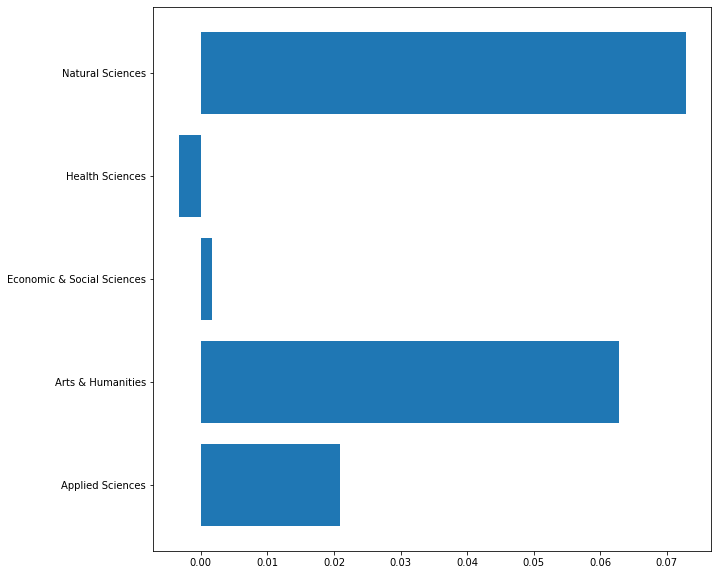

In [0]:
import matplotlib.pyplot as plt 
domain = dummy['Domain_English'].unique()
diff = []
fig = plt.figure(figsize =(10, 10))

tt = dummy[dummy['treatment'] == '1']
tc = dummy[dummy['treatment'] == '0']
print("treatment ",len(tt)," female ",len(tt[tt['gender'] == "female"])/len(tt)," control ",len(tc)," female ",len(tc[tc['gender'] == "female"])/len(tc))

for i in domain:
  tc = dummy[dummy['Domain_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['gender'] == 'female']) 
  c_female = len(c[c['gender'] == 'female'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append(((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))
  print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
  print("female in treat ",t_female/len(t)," female in control ",c_female/len(c))
plt.barh(domain, diff)

In [0]:
import matplotlib.pyplot as plt 
domain = dummy['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(9, 9))

for i in domain:
  tc = dummy[dummy['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_female = len(t[t['gender'] == 'female']) 
  c_female = len(c[c['gender'] == 'female'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append((((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)))*100)
  #print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
#plt.barh(domain, diff)
#plt.xlabel("relative difference of female in treatment and control group")
newdata = pd.DataFrame()
newdata['domain'] = domain
newdata['fem_diff'] = diff
print(newdata)

                                      domain   fem_diff
0          Agriculture, Fisheries & Forestry  13.616095
1                 Built Environment & Design  -0.954132
2          Enabling & Strategic Technologies   0.635841
3                                Engineering   5.916809
4   Information & Communication Technologies   3.069715
5            Communication & Textual Studies   2.713024
6                         Historical Studies -15.044988
7                      Philosophy & Theology  14.567538
8                   Visual & Performing Arts -71.428571
9                      Economics & Business   20.670381
10                           Social Sciences  -8.250416
11                       Biomedical Research  -9.773949
12                         Clinical Medicine   2.435721
13           Psychology & Cognitive Sciences  -1.523578
14           Public Health & Health Services  -8.142624
15                                   Biology  -0.483921
16                                 Chemistry   1

In [0]:
import matplotlib.pyplot as plt 
domain = dummy['Field_English'].unique()
diff = []
fig = plt.figure(figsize =(9, 9))

for i in domain:
  tc = dummy[dummy['Field_English'] == i]
  t = tc[tc['treatment'] == '1']
  c = tc[tc['treatment'] == '0']

  t_male = len(t[t['gender'] == 'male']) 
  c_male = len(c[c['gender'] == 'male'])

  #print("domain ",i," , treatment: ",(t_female/len(t))*100, " control: ",(c_female/len(c)*100))
  diff.append((((t_male/len(t)) - (c_male/len(c)))/(c_male/len(c)))*100)
  #print(i," ",((t_female/len(t)) - (c_female/len(c)))/(c_female/len(c)), " treatment length ",len(t)," control length ",len(c))
#plt.barh(domain, diff)
#plt.xlabel("relative difference of female in treatment and control group")
newdata = pd.DataFrame()
newdata['domain'] = domain
newdata['male_diff'] = diff
print(newdata)

                                      domain  male_diff
0          Agriculture, Fisheries & Forestry  -8.228282
1                 Built Environment & Design   0.539711
2          Enabling & Strategic Technologies  -0.184553
3                                Engineering  -2.054666
4   Information & Communication Technologies  -1.376219
5            Communication & Textual Studies  -2.824466
6                         Historical Studies  14.988535
7                      Philosophy & Theology  -6.052465
8                   Visual & Performing Arts  71.428571
9                      Economics & Business   -8.547116
10                           Social Sciences   9.716372
11                       Biomedical Research   5.577238
12                         Clinical Medicine  -1.350331
13           Psychology & Cognitive Sciences   2.022064
14           Public Health & Health Services  14.916289
15                                   Biology   0.306408
16                                 Chemistry  -0

### regression analysis on domain level documented in paper, controlling for covid is not necessary as controlling for year

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')

In [0]:
def domain22(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t[t['gender'] == "female"])/len(t))
  print("length of control ",len(c[c['gender'] == "female"])/len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []

  cov = []

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
      
    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)
  

  a['outcome'] = out

  a['covid'] = cov
  #a['oa'] = oa

  return a
  


#tmp = domain22("Physics & Astronomy",dummy.copy(deep=True)) #est = 0.0564479  0.0527718, p val = 0.28
#print(tmp.dtypes)
#tmp = domain22("Mathematics & Statistics",dummy.copy(deep=True))   #est =  0.360994   0.268223, p val = 0.17
#tmp = domain22("Earth & Environmental Sciences",dummy.copy(deep=True))  #est = -0.0710041  0.0448978, p val insig
#tmp = domain22("Chemistry",dummy.copy(deep=True))  #est = 1.756e-02  6.465e-02, insig
#tmp = domain22("Biology",dummy.copy(deep=True)) #est = -0.0123227  0.0343743, insig 
#tmp = domain22("Public Health & Health Services",dummy.copy(deep=True))  # gender est = 0.0839409  0.0255190, p value = 0.001004 ** 
#tmp = domain22("Psychology & Cognitive Sciences",dummy.copy(deep=True)) #opposite   #gender est -0.114584   0.036990, p value = 0.00195 **
#tmp = domain22("Clinical Medicine",dummy.copy(deep=True)) #est = 2.436e-03  1.132e-02, insig
#tmp = domain22("Biomedical Research",dummy.copy(deep=True))  #gender est =  0.0425387  0.0226143, p val = 0.05996 .

#tmp = domain22("Social Sciences",dummy.copy(deep=True)) #gender est =  0.0956369  0.0420042, p value = 0.0228 *
#tmp = domain22("Economics & Business ",dummy.copy(deep=True)) #gender est = -0.200888   0.055441, p value = 0.000291 ***
#tmp = domain22("Visual & Performing Arts",dummy.copy(deep=True)) ##too small sample size
#tmp = domain22("Philosophy & Theology",dummy.copy(deep=True)) #est = 0.084886   0.239748, insig 
#tmp = domain22("Historical Studies",dummy.copy(deep=True)) #gender est = 0.2448323  0.1274979, p val = 0.0548 .

#tmp = domain22("Communication & Textual Studies",dummy.copy(deep=True))  #gender est = -0.190563   0.100530, p val=  0.058 .
#tmp = domain22("Information & Communication Technologies",dummy.copy(deep=True))  #gender est = -0.2247745  0.0872372, p val = 0.00998 **
#tmp = domain22("Engineering",dummy.copy(deep=True))  #gender est = -0.159315   0.083196, p val = 0.0555 . 
#tmp = domain22("Enabling & Strategic Technologies",dummy.copy(deep=True))  #est = -3.033e-02  4.353e-02 #insig
#tmp = domain22("Built Environment & Design",dummy.copy(deep=True)) #est = 0.205768   0.167424, insig
tmp = domain22("Agriculture, Fisheries & Forestry",dummy.copy(deep=True)) #gendermale est = -0.1430302  0.0631895, p val = 0.0236 *

#print(tmp.tail(10))



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('outcome')
col_2 = ro.vectors.FactorVector(tst_df.rx2('outcome'))
tst_df[col_2_index] = col_2

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size+openaccess_status",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

9837
length of treatment  0.4279661016949153
length of control  0.37667735423346393
<command-2482583978944030>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['outcome'] = out
<command-2482583978944030>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['covid'] = cov

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contra

In [0]:
domain = dummy['Field_English'].unique()
female = []

for i in domain:
  tc = dummy[dummy['Field_English'] == i]
  tc = tc[tc['treatment'] == '1']
  tc_female = len(tc[tc['gender'] == 'female']) 
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 10))
 
samp = pd.DataFrame()
samp['domain'] = domain
samp['female_treatment'] = female

samp = samp.sort_values(by = ['female_treatment'], ascending=False)




female = []

for i in domain:
  tc = dummy[dummy['Field_English'] == i]
  tc = tc[tc['treatment'] == '0']
  tc_female = len(tc[tc['gender'] == 'female'])
  female.append((tc_female/len(tc))*100)

print("domain ",domain)
print("female percent ", female)
fig = plt.figure(figsize =(10, 10))
 
samp2 = pd.DataFrame()
samp2['domain'] = domain
samp2['female_control'] = female

samp2 = samp2.sort_values(by = ['female_control'], ascending=False)

merge = samp.merge(samp2, on = ['domain'], how = "inner")
print(merge)

#### domain distribution in control and treatment group

In [0]:
treat_len = len(new[new['treatment'] == '1'])
con_len = len(new[new['treatment'] == '0'])
print(treat_len," ",con_len)
for i in new['Domain_English'].unique():
    ii = new[new['Domain_English'] == i]
    it = ii[ii['treatment'] == '1']
    ic = ii[ii['treatment'] == '0']
    print(i," tratment ",len(it)," control ",len(ic), " treatment percent ", len(it)/treat_len," control percent ",len(ic)/con_len)

## Affiliation Analysis

In [0]:
import pandas as pd
total = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")
#print(total.dtypes)

#print("len of total ", len(total))
#print(total['doi'].nunique())
total = total.drop_duplicates(subset = ['doi'])

print("len of total after dropping duplicate dois ", len(total))

ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total2 = total[~total['doi'].isin(ids_to_remove)]
us = total[total['country_name'] == 'United States']
print(len(us))
print(len(us[us['news_cnt'] > 0]))
print(len(us[us['news_cnt'] <= 0]))


dummy = us.copy()
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        gender.append("female")
    else: ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        gender.append("male")
dummy['gender'] = gender

In [0]:
dummy['org_type'].unique()

In [0]:
new = new.sort_values(by = ['strata'])
print(new.head(30))

In [0]:
a = new['strata'].unique()
for i in a:
    f = new[new['strata'] == i]
    g1 = f[f['treatment'] == '1']
    g0 = f[f['treatment'] == '0']
    if len(g0)<= 0 or len(g1)<= 0:
        print("problem")
        print("strata ",i)
        break

In [0]:
a = new['strata'].unique()
for i in a:
    f = new[new['strata'] == i]
    if f['srcid'].nunique() != 1:
        print("prob")
        break
    if f['openaccess_status'].nunique() != 1:
        print("prob")
        break
    if f['year_cat'].nunique() != 1:
        print("prob")
        break
    if f['team_size'].nunique() != 1:
        print("prob")
        break
    if f['subfield_article'].nunique() != 1:
        print("prob")
        break
#'srcid','openaccess_status','year_cat','team_size','subfield_article'

In [0]:
x = new.drop_duplicates(subset = ['srcid','openaccess_status','year_cat','team_size','subfield_article'])
print(len(x))
print(new['strata'].nunique())

In [0]:
print(len(new))
print(len(new[new['treatment'] == '1']))

In [0]:
import numpy as np
np.exp(0.0839409)

In [0]:
#https://stackoverflow.com/questions/41384075/r-calculate-and-interpret-odds-ratio-in-logistic-regression
#https://stats.stackexchange.com/questions/304833/how-to-calculate-odds-ratio-and-95-confidence-interval-for-logistic-regression
#https://stackoverflow.com/questions/11561258/r-python-install-packages-on-rpy2
#https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
#https://www.practicalpythonfordatascience.com/ap_seaborn_palette - great color palettes
#https://stats.stackexchange.com/questions/5304/why-is-there-a-difference-between-manually-calculating-a-logistic-regression-95/5320#5320 
#https://stats.oarc.ucla.edu/r/dae/poisson-regression/ 
#https://rstudio-pubs-static.s3.amazonaws.com/565937_c92bc7ce744545b6b3b5c70cc4db1e7a.html#:~:text=Reference%20group%20of%20the%20outcome,0)%20is%20the%20reference%20group!

In [0]:
dummy['Domain_English'].unique()

Out[11]: array(['Applied Sciences', 'Arts & Humanities',
       'Economic & Social Sciences', 'Health Sciences',
       'Natural Sciences'], dtype=object)

In [0]:
a = dummy[dummy['Domain_English'] == 'Applied Sciences']
print(a['Field_English'].unique())

['Agriculture, Fisheries & Forestry' 'Built Environment & Design'
 'Enabling & Strategic Technologies' 'Engineering'
 'Information & Communication Technologies']


In [0]:
a = dummy[dummy['Domain_English'] == 'Arts & Humanities']
print(a['Field_English'].unique())

['Communication & Textual Studies' 'Historical Studies'
 'Philosophy & Theology' 'Visual & Performing Arts']


In [0]:
a = dummy[dummy['Domain_English'] == 'Economic & Social Sciences']
print(a['Field_English'].unique())

['Economics & Business ' 'Social Sciences']


In [0]:
a = dummy[dummy['Domain_English'] == 'Health Sciences']
print(a['Field_English'].unique())

['Biomedical Research' 'Clinical Medicine'
 'Psychology & Cognitive Sciences' 'Public Health & Health Services']


In [0]:
a = dummy[dummy['Domain_English'] == 'Natural Sciences']
print(a['Field_English'].unique())

['Biology' 'Chemistry' 'Earth & Environmental Sciences'
 'Mathematics & Statistics' 'Physics & Astronomy']


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = {
    "domain": ["A", "B", "C", "D"],
    "odds_ratio": [1.5, 2.0, 1.8, 2.2],
    "left_ci": [1.2, 1.8, 1.5, 2.0],
    "right_ci": [1.8, 2.2, 2.1, 2.5],
    "significance": ["*", "**", "", "*"],
    "gender": [0, 1, 0, 1]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Add confidence interval lines with dots for odds ratio, color-coded by gender
for i, row in df.iterrows():
    color = "red" if row["gender"] == 0 else "black"
    plt.plot(row["odds_ratio"], i, 'o', markersize=8, color=color)
    plt.plot([row["left_ci"], row["right_ci"]], [i, i], color=color, linewidth=2)

# Annotate significance
for i, row in df.iterrows():
    plt.text(row["right_ci"] + 0.02, i, row["significance"], color="red" if row["gender"] == 0 else "black",
             verticalalignment="center", fontsize=12)

# Customize the plot
plt.yticks(range(len(df)), df["domain"])
plt.xlabel("Odds Ratio", fontsize=14)
plt.title("Odds Ratio with Confidence Intervals", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Show the plot
plt.show()




In [0]:
import math
#math.exp(1.4345)
math.exp(1.4345+1.96*0.5346)
print(math.exp(-0.2247745))

0.7986963044706081


In [0]:
a = pd.DataFrame()
a['field'] = ["Physics & Astronomy","Mathematics & Statistics","Earth & Environmental Sciences","Chemistry","Biology","Public Health & Health Services","Psychology & Cognitive Sciences",
"Clinical Medicine","Biomedical Research","Social Sciences","Economics & Business","Philosophy & Theology","Historical Studies","Communication & Textual Studies","Information & Communication Technologies","Engineering","Enabling & Strategic Technologies","Built Environment & Design","Agriculture, Fisheries & Forestry"]
a['est'] = [0.056,0.36,-0.0710,1.756e-02,-0.0123227,0.0839409,-0.114584,2.436e-03,0.0425387,0.0956369,-0.200888,0.084886,0.2448323,-0.190563,-0.2247745,-0.159315,-3.033e-02,0.205768,-0.1430302]
a['error'] = [0.0527,0.268, 0.0448,6.465e-02, 0.0343743,0.0255190,0.036990,1.132e-02,0.0226143,0.0420042,0.055441,0.239748,0.1274979,0.100530,0.0872372,0.083196,4.353e-02,0.167424,0.0631895]
a['pval'] = [" "," "," "," "," ","**","**"," ",".","*","***"," ",".",".","**","."," "," ","*"]
a['gender'] = a['est'].apply(lambda x: 1 if x > 0 else 0)
#print(a)

a['odds_ratio'] = a['est'].apply(lambda x: math.exp(x))

left_ci = []
right_ci = []

for ind in a.index:
    left_ci.append(math.exp(a['est'][ind] - 1.96 * a['error'][ind]))
    right_ci.append(math.exp(a['est'][ind] + 1.96 * a['error'][ind]))

a['left_ci'] = left_ci
a['right_ci'] = right_ci
print(a)

                                       field       est     error pval  gender  \
0                        Physics & Astronomy  0.056000  0.052700            1   
1                   Mathematics & Statistics  0.360000  0.268000            1   
2             Earth & Environmental Sciences -0.071000  0.044800            0   
3                                  Chemistry  0.017560  0.064650            1   
4                                    Biology -0.012323  0.034374            0   
5            Public Health & Health Services  0.083941  0.025519   **       1   
6            Psychology & Cognitive Sciences -0.114584  0.036990   **       0   
7                          Clinical Medicine  0.002436  0.011320            1   
8                        Biomedical Research  0.042539  0.022614    .       1   
9                            Social Sciences  0.095637  0.042004    *       1   
10                      Economics & Business -0.200888  0.055441  ***       0   
11                     Philo

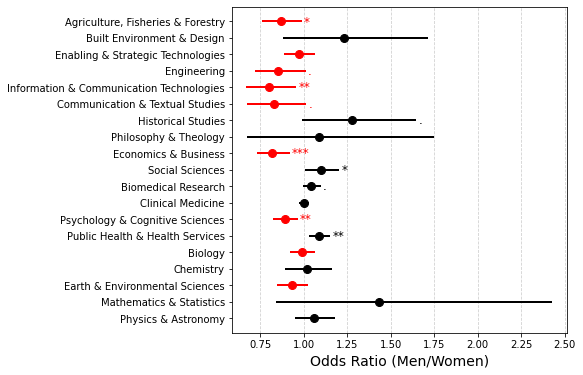

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns



# Create a DataFrame
df = a.copy()

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))

# Add confidence interval lines with dots for odds ratio, color-coded by gender
for i, row in df.iterrows():
    color = "red" if row["gender"] == 0 else "black"
    plt.plot(row["odds_ratio"], i, 'o', markersize=8, color=color)
    plt.plot([row["left_ci"], row["right_ci"]], [i, i], color=color, linewidth=2)

# Annotate significance
for i, row in df.iterrows():
    plt.text(row["right_ci"] + 0.02, i, row["pval"], color="red" if row["gender"] == 0 else "black",
             verticalalignment="center", fontsize=12)

# Customize the plot
plt.yticks(range(len(df)), df["field"])
plt.xlabel("Odds Ratio (Men/Women)", fontsize=14)
#plt.title("Odds Ratio with Confidence Intervals", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [0]:
#a = sns.color_palette(palette='BuGn')
#a = sns.color_palette(palette='PuBu')
a = sns.color_palette(palette='tab20')
print(a.as_hex())

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


In [0]:
dummy = new.copy(deep = True)
print(len(dummy))
dummy = dummy.dropna(subset = ['cor_gender'])
print(len(dummy))
gender = []
for ind in dummy.index:
    if dummy['cor_gender'][ind] == "female" or dummy['cor_gender'][ind] == "f" or dummy['cor_gender'][ind] == "F":
        #gender.append("female")
        #gender.append("bfemale")
        gender.append(1)
    elif dummy['cor_gender'][ind] == "male" or dummy['cor_gender'][ind] == "m" or dummy['cor_gender'][ind] == "M": ##there is no null value in gender, so it is safe to say that if someone is not female, he must be male
        #gender.append("male")
        #gender.append("amale")
        gender.append(0)
dummy['gender'] = gender

q1, q2, q3 = 0.124, 0.25, 0.597

print("q1 ",q1," q2 ",q2," q3 ",q3)
q = []
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

421038
421038
q1  0.124  q2  0.25  q3  0.597


In [0]:
def domain24(i, new):
  a = new[new['Field_English'] == i]
  print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t[t['gender'] == 1])/len(t))
  print("length of control ",len(c[c['gender'] == 1])/len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []

  cov = []

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
      
    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)
  

  a['outcome'] = out

  a['covid'] = cov
  #a['oa'] = oa

  return a
  


#tmp = domain24("Physics & Astronomy",dummy.copy(deep=True)) #est = 0.0564479  0.0527718, p val = 0.2848
#print(tmp.dtypes)
tmp = domain24("Mathematics & Statistics",dummy.copy(deep=True))   #est =  0.360994   0.268223, p val = 0.17
#tmp = domain24("Earth & Environmental Sciences",dummy.copy(deep=True))  #est = -0.0710041  0.0448978, p val insig
#tmp = domain24("Chemistry",dummy.copy(deep=True))  #est = 1.756e-02  6.465e-02, insig
#tmp = domain24("Biology",dummy.copy(deep=True)) #est = -0.0123227  0.0343743, insig 
#tmp = domain24("Public Health & Health Services",dummy.copy(deep=True))  # gender est = 0.0839409  0.0255190, p value = 0.001004 ** 
#tmp = domain24("Psychology & Cognitive Sciences",dummy.copy(deep=True)) #opposite   #gender est -0.114584   0.036990, p value = 0.00195 **
#tmp = domain24("Clinical Medicine",dummy.copy(deep=True)) #est = 2.436e-03  1.132e-02, insig
#tmp = domain24("Biomedical Research",dummy.copy(deep=True))  #gender est =  0.0425387  0.0226143, p val = 0.05996 .

#tmp = domain24("Social Sciences",dummy.copy(deep=True)) #gender est =  0.0956369  0.0420042, p value = 0.0228 *
#tmp = domain24("Economics & Business ",dummy.copy(deep=True)) #gender est = -0.200888   0.055441, p value = 0.000291 ***
#tmp = domain24("Visual & Performing Arts",dummy.copy(deep=True)) ##too small sample size
#tmp = domain24("Philosophy & Theology",dummy.copy(deep=True)) #est = 0.084886   0.239748, insig 
#tmp = domain24("Historical Studies",dummy.copy(deep=True)) #gender est = 0.2448323  0.1274979, p val = 0.0548 .

#tmp = domain24("Communication & Textual Studies",dummy.copy(deep=True))  #gender est = -0.190563   0.100530, p val=  0.058 .
#tmp = domain24("Information & Communication Technologies",dummy.copy(deep=True))  #gender est = -0.2247745  0.0872372, p val = 0.00998 **
#tmp = domain24("Engineering",dummy.copy(deep=True))  #gender est = -0.159315   0.083196, p val = 0.0555 . 
#tmp = domain24("Enabling & Strategic Technologies",dummy.copy(deep=True))  #est = -3.033e-02  4.353e-02 #insig
#tmp = domain24("Built Environment & Design",dummy.copy(deep=True)) #est = 0.205768   0.167424, insig
#tmp = domain24("Agriculture, Fisheries & Forestry",dummy.copy(deep=True)) #gendermale est = -0.1430302  0.0631895, p val = 0.0236 *

#print(tmp.tail(10))



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('subfield_article')
col_2 = ro.vectors.FactorVector(tst_df.rx2('subfield_article'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('outcome')
col_2 = ro.vectors.FactorVector(tst_df.rx2('outcome'))
tst_df[col_2_index] = col_2'''

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+subfield_article+team_size+openaccess_status",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

1020
length of treatment  0.25
length of control  0.28043478260869564
<command-3425889846512629>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['outcome'] = out
<command-3425889846512629>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['covid'] = cov

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ..

In [0]:
a = stats.confint_default(model)
print(a)

                                                  2.5 %      97.5 %
(Intercept)                                  -2.2361908 -0.09741855
gender1                                      -0.5339141  0.12237761
year2019                                     -0.5593746  0.55044565
year2020                                     -0.5326907  0.53734820
year2021                                     -0.5402332  0.53532384
year2022                                     -0.5712648  0.58200909
q3                                           -0.8116610  0.83777782
subfield_articledesign practice & management -1.3560550  1.34409974
subfield_articleurban & regional planning    -0.4326599  0.46350962
team_size2                                   -0.4576243  0.48117594
team_size3                                   -0.5146171  0.50301868
team_size4                                   -0.4963143  0.50659356
team_size5                                   -0.6440454  0.67901303
team_size6                                   -0.

In [0]:
def domainx(a):
  #a = new[new['Field_English'] == i]
  #print(len(a))

  t = a[a['treatment'] == '1']
  c = a[a['treatment'] == '0']
  print("length of treatment ",len(t[t['gender'] == 1])/len(t))
  print("length of control ",len(c[c['gender'] == 1])/len(c))

  con_18,con_19,con_20,con_21,con_22 = [],[],[],[],[]
  t1,t2,t3,t4,t5,t6 = [],[],[],[],[],[]
  #oa = []

  out = []

  cov = []

  for ind in a.index:
    if a['year'][ind] == 2018 or a['year'][ind] == 2019:
      cov.append(0)
    else:
      cov.append(1)
      
    if a['treatment'][ind] == '1':
      out.append(1)
    else:
      out.append(0)
  

  a['outcome'] = out

  a['covid'] = cov
  #a['oa'] = oa

  return a
  


tmp = domainx(dummy.copy(deep=True)) #est = 0.0564479  0.0527718, p val = 0.2848



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('team_size')
col_2 = ro.vectors.FactorVector(tst_df.rx2('team_size'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('covid')
col_2 = ro.vectors.FactorVector(tst_df.rx2('covid'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('outcome')
col_2 = ro.vectors.FactorVector(tst_df.rx2('outcome'))
tst_df[col_2_index] = col_2'''

#print(tst_df)
#pandas2ri.activate()
model = stats.glm("outcome ~ gender+year+q+Field_English+team_size+openaccess_status",
                  data=tst_df, weights = tst_df.rx2('weight'),family=ro.r('binomial(link="logit")'))
print(base.summary(model))

length of treatment  0.3805604566683965
length of control  0.37335226432760066

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (ide